***
# <font color=#ff4013 size=10>Trabalho Final</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

José Ronaldo Agra de Souza Filho - 22/0005427
Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [8]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
import seaborn as sns
import ciw
import time
import matplotlib.pyplot as plt
import csv
import os

**Definindo constantes globais.**

In [9]:
# Valor da semente padrão
SEED = 42
M = 100000
NOME_ARQUIVO_FILAS = 'filas_simuladas.csv'

---

## <font color=#008cb4>Contexto</font>

---


"*A teoria das filas é um ramo da probabilidade que estuda a formação de filas, através de análises matemáticas precisas e propriedades mensuráveis das filas.*" (Wikipedia)

---
## <font color=#008cb4>Problema</font>

---

Considere uma fila do tipo M/M/2 (veja o artigo citado abaixo ou qualquer outra referência sobre Teoria de filas), com tempo entre chegadas distribuído por uma exponencial com parâmetro $\lambda$ e tempo de atendimento por uma exponencial com parâmetro $\mu$. Suponha que uma empresa atenda, no máximo, 200 clientes por dia, e que, em um dado dia, foi registrado tempo médio de espera na fila de duas horas e 30 minutos e comprimento médio da fila de 22 pessoas. Note que como os dados de cada cliente não foram disponibilizados, a verossimilhança não pode ser calculada facilmente. Faça um estudo de simulação para responder as perguntas elencadas a seguir.


---

## <font color=#008cb4>Material de estudo</font>

---

[https://arxiv.org/pdf/1703.02151.pdf](https://arxiv.org/pdf/1703.02151.pdf)

![Normal](queue.png)

---

## <font color=#008cb4>Questões de interesse</font>

---

### Usando Computação Bayesiana Aproximada (ABC), estime a distribuição a posteriori para os parâmetros $\lambda$ e $\mu$.

---

Definindo a função para criação de filas a partir de parâmetros $\lambda$ e $\mu$.

In [3]:
def cria_fila_simulada(lambda_priori, mu_priori, num_servidores=2, tam_max_fila=200, seed=1914) -> pd.DataFrame:
    """
    Função para gerar uma fila simulada com base nos parâmetros específicados.
    :param lambda_priori: O lambda definido a priori.
    :param mu_priori: O mu definido a priori.
    :param num_servidores: O número de servidores da fila. Padrão = 2.
    :param tam_max_fila: O tamanho máximo da fila. Padrão = 200.
    :param seed: A semente utilizada na geração dos estatisticas aleatórios. Padrão = 1914.
    :return: Um dataframe, com os estatisticas da fila gerada. O dataframe possuie as seguintes colunas: chegadas,
            tempo_servico, partidas, tempo_espera, atendente, tam_fila_chegada, tam_fila_partida
    """
    # Cria uma rede M/M/2 com os parâmetros definidos a priori
    N = ciw.create_network(
         arrival_distributions=[ciw.dists.Exponential(rate=lambda_priori)],
         service_distributions=[ciw.dists.Exponential(rate=mu_priori)],
         number_of_servers=[num_servidores]
    )

    # Define uma semente
    ciw.seed(seed)
    # Cria uma simulação
    Q = ciw.Simulation(N)
    # Roda a simulação até o máximo de clientes atendidos por dia (n = 200)
    Q.simulate_until_max_customers(tam_max_fila)

    # Pega os registros de atendimento e gera dataframe
    registros = Q.get_all_records()
    chegadas = []
    partidas = []
    tempo_servico = []
    tempo_espera = []
    atendente = []
    tam_fila_chegada = []
    for registro in registros:
         chegadas.append(registro.arrival_date)
         tempo_servico.append(registro.service_time)
         partidas.append(registro.exit_date)
         tempo_espera.append(registro.waiting_time)
         atendente.append(registro.server_id)
         tam_fila_chegada.append(registro.queue_size_at_arrival)

    # Cria o dataframe
    fila = pd.DataFrame(zip(chegadas, tempo_servico, partidas, tempo_espera, atendente,
                                   tam_fila_chegada),
                         columns=["chegadas", "tempo_servico", "partidas", "tempo_espera", "atendente",
                                  "tam_fila_chegada"])
    # Ordena, por ordem de chegadas, e calcula a diferença entre as chegadas
    fila.sort_values("chegadas", inplace=True)
    fila["tempo_entre_chegadas"] = fila.chegadas.diff()
    fila.fillna(0, inplace=True)

    return fila

Rodando a simulação para M (= 10.000) dados sintéticos com os parâmetros definidos a priori.

In [22]:
# Define o array [tempo_medio_espera, tamanho_medio_fila] a partir da observação
valores_obs = [150, 22]     # tempo médio = 150 min, e tamanho_medio = 22 pessoas

tempo_inicial = time.time()

# Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
amostras = []

# Verifica se o arquivo já existe
if os.path.exists(NOME_ARQUIVO_FILAS):
    # Carrega os dados do arquivo e armazena na lista 'amostras'

    with open(NOME_ARQUIVO_FILAS, 'r') as csvfile:
        # Skip da primeira linha do arquivo (cabeçalho)
        next(csvfile)

        # Cria o objeto csv.reader
        reader = csv.reader(csvfile)

        # Lê todas as outras linhas do arquivo
        #amostras = csvfile.readlines()

        # Itera sobre as linhas do arquivo
        for linha in reader:
            # Adiciona a linha à lista - converte os dados em float
            amostras.append([float(i) for i in linha])

else:
    # Executa uma simulação para a geração das filas
    # Gera amostras aleatórias de λ e μ a partir da distribuição a priori
    np.random.seed(SEED)
    lam = np.random.uniform(size=M)
    mu = np.random.uniform(size=M)

    # Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
    for i in range(M):
        # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
        fila = cria_fila_simulada(lam[i], mu[i])
        # Os valores simulados para a fila gerada
        valores_sim = [fila.tempo_espera.mean(), fila.tam_fila_chegada.mean()]
        # Calcula a distância entre os estatisticas simulados e os estatisticas reais
        amostras.append([lam[i], mu[i], *valores_sim, distance.euclidean(valores_sim, valores_obs)])

tempo_final = time.time()
print('Tempo da simulação: ', (tempo_final - tempo_inicial))

Tempo da simulação:  0.44040536880493164


In [23]:
# Gera um arquivo CSV, com as filas criadas, com o objetivo de evitar a geração das mesmas a cada execução

# Verifica se o arquivo já existe
if not os.path.exists(NOME_ARQUIVO_FILAS):
    # Cabeçalho do arquivo
    campos = ['Lambda', 'Mu', 'Tempo_Espera_Medio', 'Tam_Fila_Medio', 'Distancia']

    # Abre o arquivo para escrita
    with open(NOME_ARQUIVO_FILAS, 'w', newline='') as csvfile:
        # Cria o objeto csv.writer
        writer = csv.writer(csvfile)

        # Escreve o cabeçalho
        writer.writerow(campos)
        # Escreve o conteúdo da simulação no arquivo
        writer.writerows(amostras)

Gerando o dataframe com as estatísticas.

In [25]:
# Gera um dataframe Pandas com os parâmetros e as estatísticas calculadas
amostras_posteriori = pd.DataFrame(amostras, columns=["lambda", "mu", "tempo_medio_espera", "tam_medio_fila", "distancia"])
## Obtem o inverso da matriz de covariância
# inv_cov = np.linalg.inv(amostras_posteriori[["tempo_medio_espera", "tam_medio_fila"]].cov())
## Calcula a distância em relação aos valores observados
# amostras_posteriori["distancia"] = amostras_posteriori.apply(lambda x: distance.mahalanobis([x["tempo_medio_espera"], x["tam_medio_fila"]], valores_obs, inv_cov), axis=1)

# recupera os 1% registros que tiveram as menores distâncias
amostras_posteriori = amostras_posteriori.nsmallest(int(M * 0.01), "distancia")
amostras_posteriori

,lambda,mu,tempo_medio_espera,tam_medio_fila,distancia
32988,0.181440,0.068273,150.612399,21.250,0.968263
682,0.170888,0.076536,150.633213,22.855,1.063947
32399,0.217739,0.084489,151.269793,22.820,1.511547
87231,0.210119,0.076422,148.475351,22.375,1.570089
65563,0.200939,0.078733,153.120644,22.350,3.140211
...,...,...,...,...,...
47402,0.816941,0.164987,160.563634,51.870,31.682917
18603,0.642694,0.174084,130.433670,46.930,31.691421
28537,0.695303,0.189222,134.529613,49.685,31.714226
13723,0.219925,0.092181,180.417676,31.015,31.725467


<font color='red'>**Resposta:**</font>

O intervalo de confiança (95%) e os histogramas a seguir mostram as distribuições a posteriori para os parâmetros $\lambda$ e $\mu$ respectivamente. Para a resolução da questão, foram avaliadas duas distâncias: euclidiana e de Mahalanobis. Por mostrar menor variabilidade em relação aos valores do tempo médio de espera e tamanho médio da fila, a primeira foi escolhida em detrimento da segunda.

In [26]:
amostras_posteriori[["lambda", "mu"]].quantile([0.025, 0.975])

,lambda,mu
0.025,0.130158,0.057182
0.975,0.841564,0.192502


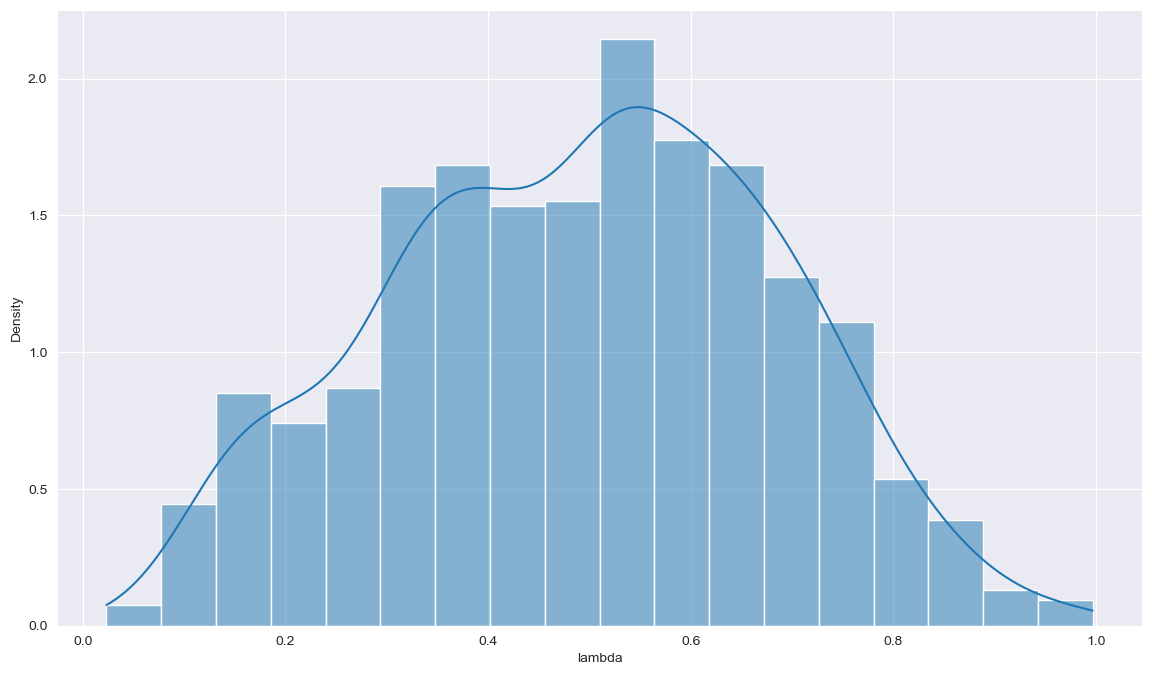

In [27]:
ax = sns.histplot(amostras_posteriori["lambda"], kde=True, stat="density")
ax.figure.set_size_inches(14, 8)

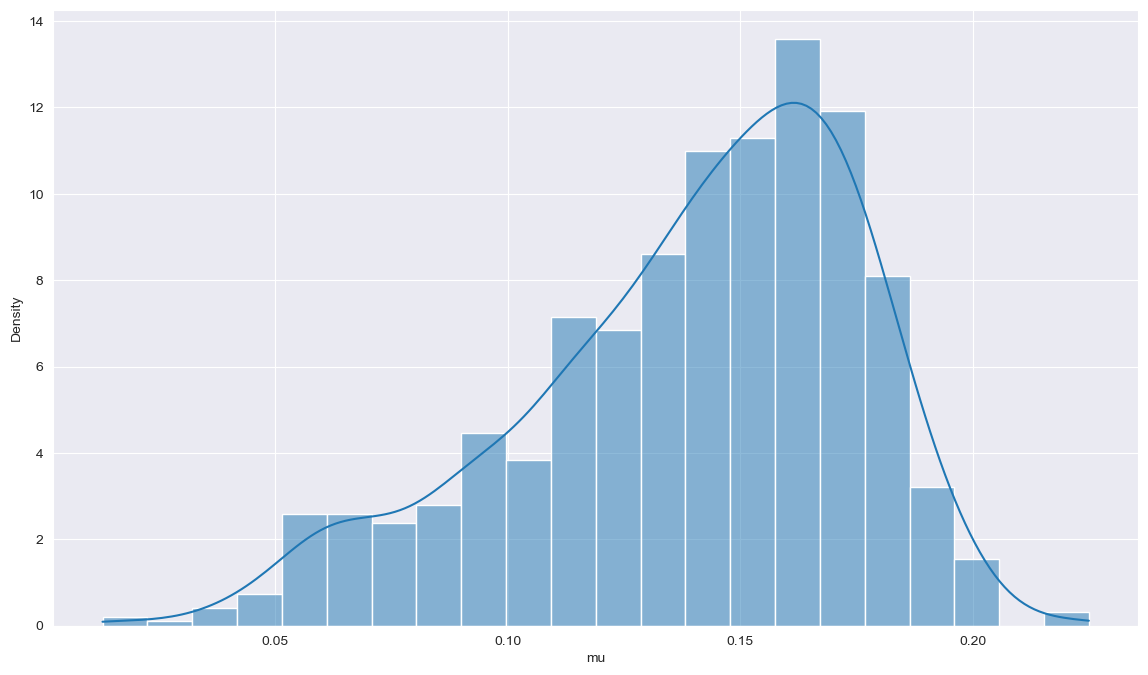

In [28]:
ax = sns.histplot(amostras_posteriori["mu"], kde=True, stat="density")
ax.figure.set_size_inches(14, 8)

### Teste a hipótese nula de que o tempo médio de atendimento é inferior à metade do tempo médio entre chegadas.

---

In [29]:
tempo_inicial = time.time()

# Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
estatisticas = []

# Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
for amostra in amostras_posteriori[["lambda", "mu"]].values:
    # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
    fila = cria_fila_simulada(amostra[0], amostra[1])
    # Calcula a distância entre os estatisticas simulados e os estatisticas reais
    estatisticas.append([fila.tempo_servico.mean(), fila.tempo_entre_chegadas.mean()])

tempo_final = time.time()
print('Tempo da simulação: ', (tempo_final - tempo_inicial))

Tempo da simulação:  10.05386233329773


In [30]:
# Gera um dataframe Pandas as estatísticas calculadas
estatisticas_posteriori = pd.DataFrame(estatisticas, columns=["tempo_medio_servico", "tempo_medio_entre_chegadas"])
estatisticas_posteriori["tempo_medio_servico"].quantile([0.025, 0.975])

0.025     5.557154
0.975    17.692295
Name: tempo_medio_servico, dtype: float64

In [31]:
print("Metade do tempo médio entre chegadas:", estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2)

Metade do tempo médio entre chegadas: 1.2611314921496477


<AxesSubplot: xlabel='tempo_medio_servico', ylabel='Density'>

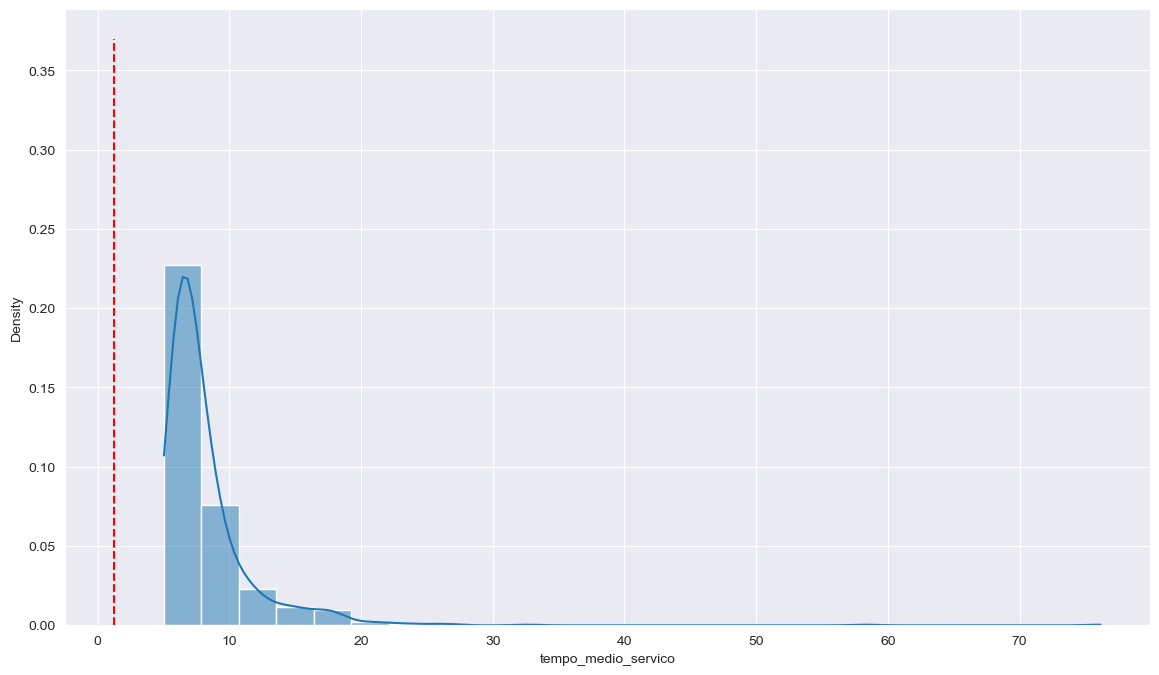

In [32]:
ax = sns.histplot(estatisticas_posteriori["tempo_medio_servico"], kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=(estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2), ymin=0, ymax=0.37, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

Considerando-se o intervalo de confiança de 95%, bem como a análise gráfica, pode-se descartar a hipótese nula ($H_{0}$) de que tempo médio de atendimento é inferior à metade do tempo médio entre chegadas.

### Caso o hospital deseje que em $90\%$ do tempo todos os pacientes na fila possam se sentar simultaneamente, quantas cadeiras seriam necessárias? Dica: para cada amostra da posteriori, simule uma fila e calcule a estatística desejada. Em seguida, construa um intervalo de credibilidade.

---

In [33]:
tempo_inicial = time.time()

# Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
estatisticas = []
# para avaliarmos e decidirmos depois
est_2 = []

# Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
for amostra in amostras_posteriori[["lambda", "mu"]].values:
    # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
    fila = cria_fila_simulada(amostra[0], amostra[1])
    # Adiciona no array de estatistias a média do tamanho da fila
    estatisticas.append([fila.tam_fila_chegada.mean()])
    # Calcula o quantil 90% do tamanho da fila
    est_2.append(fila.tam_fila_chegada.quantile([0.9]).values[0])

tempo_final = time.time()
print('Tempo da simulação: ', (tempo_final - tempo_inicial))

Tempo da simulação:  10.110947608947754


In [34]:
print('Média dos quantis 90% dos tamanhos das filas:', np.array(est_2).mean())

# Gera um dataframe Pandas para as estatísticas calculadas
estatisticas_posteriori_tam = pd.DataFrame(estatisticas, columns=["tam_fila_chegada"])
estatisticas_posteriori_tam["tam_fila_chegada"].quantile([0.9])

Média dos quantis 90% dos tamanhos das filas: 71.5227


0.9    51.086
Name: tam_fila_chegada, dtype: float64

<font color='red'>**Resposta:**</font>

Considerando-se o intervalo de confiança de 90%, pode-se afirmar que seriam necessárias 50 cadeiras para que todos os pacientes na fila pudessem se sentar simultaneamente.

### Avalie se o tempo de espera reduziria caso houvesse duas filas de atendimento independentes (considerando os mesmos parâmetros estimados anteriormente - veja a figura acima).

---

### O tamanho da fila é um desestímulo aos pacientes. Ao ver uma fila grande, o paciente desiste do atendimento com certa probabilidade. Incorpore essa característica à sua simulação e estime quantas pessoas desestiram do atendimento no dia em que os dados foram coletados. Essa é uma atividade desafiadora! Justifique suas suposições.

---